In [1]:
# 1) python -m unittest hw_asr.tests.test_config hw_asr.tests.test_datasets
# 2) python -m unittest hw_asr.tests.test_text_encoder
# 3) python -m unittest hw_asr.tests.test_dataloader
# python -m unittest discover hw_asr/tests

# 4) Implement functions in `hw_asr\metric\utils.py`

# 5) Implement missing function to run `train.py` with a baseline model

In [2]:
from utils import reload

In [3]:
reload('hw_asr')

from hw_asr.datasets import LibrispeechDataset
from hw_asr.tests.utils import clear_log_folder_after_use
from hw_asr.utils.object_loading import get_dataloaders
from hw_asr.utils.parse_config import ConfigParser


config_parser = ConfigParser.get_debug_configs()
with clear_log_folder_after_use(config_parser):
    dataloaders = get_dataloaders(config_parser, config_parser.get_text_encoder())
    # ds = LibrispeechDataset(
    #     "dev-clean", text_encoder=config_parser.get_text_encoder(),
    #     config_parser=config_parser
    # )
batch = next(iter(dataloaders['train']))

The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


61 (2.3%) records are longer then 20.0 seconds. Excluding them.
292 (10.8%) records are longer then 200 characters. Excluding them.
Filtered 292(10.8%) records  from dataset
61 (2.3%) records are longer then 20.0 seconds. Excluding them.
292 (10.8%) records are longer then 200 characters. Excluding them.
Filtered 292(10.8%) records  from dataset


In [4]:
import torchaudio
from pathlib import Path
from IPython.display import Audio

reload('hw_asr')


def listen_aug(batch, ind, aug):
    audio_path = Path(batch["audio_path"][ind])
    sample_rate = torchaudio.info(audio_path).sample_rate

    print('Original:')
    original_sample = batch['audio'][ind:ind+1]
    print(original_sample.size())
    print(original_sample)
    display(Audio(original_sample, rate=sample_rate))
    
    modified_sample, name = aug(original_sample)
    print(f'Modified ({name}):')
    print(modified_sample.size())
    print(modified_sample)
    display(Audio(modified_sample, rate=sample_rate))

In [5]:
from hw_asr.augmentations.wave_augmentations import Gain

listen_aug(batch, 1, aug=Gain(p=1))

Original:
torch.Size([1, 242880])
tensor([[0.0024, 0.0035, 0.0052,  ..., 0.0000, 0.0000, 0.0000]])


Modified (['Gain']):
torch.Size([1, 242880])
tensor([[0.0019, 0.0027, 0.0039,  ..., 0.0000, 0.0000, 0.0000]])


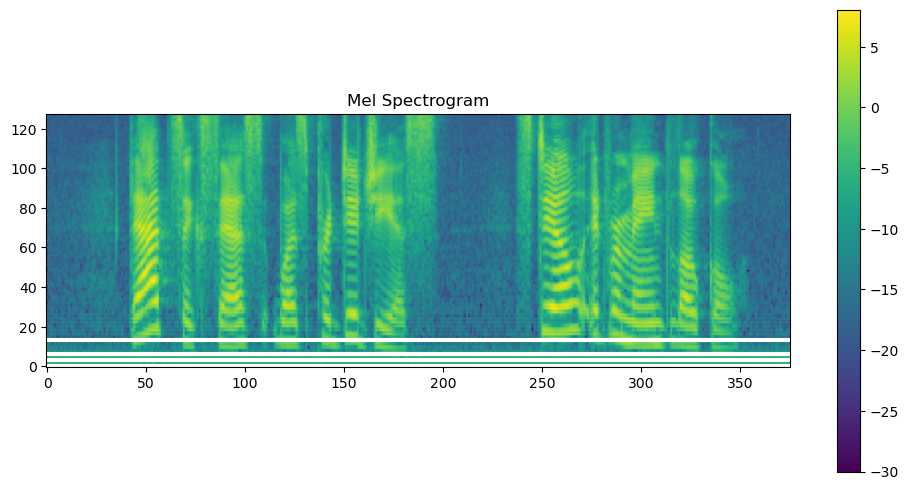

In [6]:
import torchaudio.transforms as T
import matplotlib.pyplot as plt

# Load an audio file (you can replace this with your own audio file)
sample_rate = 16000
waveform = batch['audio'][0][:batch['audio_length'][0]]

# Create a Mel spectrogram
mel_transform = T.MelSpectrogram(sample_rate=sample_rate)
mel_spectrogram = mel_transform(waveform)

# Plot the Mel spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(mel_spectrogram.log2().numpy(), cmap='viridis', origin='lower')
plt.title("Mel Spectrogram")
plt.colorbar()
plt.show()

In [8]:
reload('hw_asr')

import torch
import torch.nn.functional as F
from hw_asr.model.deep_speech import DeepSpeech2
from hw_asr.loss.CTCLossWrapper import CTCLossWrapper


def test_model(model, batch, print_results: bool=True):
    outputs = model(**batch)
    criterion = CTCLossWrapper()
    batch.update(outputs)
    batch["log_probs"] = F.log_softmax(batch["logits"], dim=-1)
    batch["log_probs_length"] = model.transform_input_lengths(batch["spectrogram_length"])
    batch["loss"] = criterion(**batch)

    if print_results:
        print(f'logits: {batch["logits"].size()}')
        print(f'log_probs: {batch["log_probs"].size()}')
        print(f'log_probs_length: {batch["log_probs_length"].size()}')
        print(f'loss: {batch["loss"]}')
        print(f'log_probs_lengths={batch["log_probs_length"]}')
    return batch


device = torch.device('cuda:0')
# device = torch.device('cpu')
# test_model(BaselineModel(n_feats=128, n_class=10), batch)


def move_batch_to_device(batch):
    batch = batch.copy()
    for tensor_for_gpu in ["spectrogram", "text_encoded"]:
        batch[tensor_for_gpu] = batch[tensor_for_gpu].to(device)
    return batch


model = DeepSpeech2(n_feats=128, n_class=10, debug=False).to(device)
%timeit test_model(model, move_batch_to_device(batch), print_results=False)

model = DeepSpeech2(n_feats=128, n_class=10, debug=False)
%timeit test_model(model, batch, print_results=False)

751 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.09 s ± 565 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
